In [607]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

datasource = pq.read_table("escooter_history.parquet")

dataset = datasource.to_pandas()

dataset

,datetime,holiday,workingday,weather,temp,atemp,humidity,windspeed,registered_customer
0,2019-01-01 00:00:09,0,0,"clear, few clouds",9.84,14.395,81,0.0000,True
1,2019-01-01 00:00:41,0,0,"clear, few clouds",9.84,14.395,81,0.0000,True
2,2019-01-01 00:01:20,0,0,"clear, few clouds",9.84,14.395,81,0.0000,True
3,2019-01-01 00:04:12,0,0,"clear, few clouds",9.84,14.395,81,0.0000,True
4,2019-01-01 00:15:19,0,0,"clear, few clouds",9.84,14.395,81,0.0000,True
...,...,...,...,...,...,...,...,...,...
3296016,2020-12-31 23:55:56,0,1,"clear, few clouds",10.66,13.635,65,8.9981,True
3296017,2020-12-31 23:55:59,0,1,"clear, few clouds",10.66,13.635,65,8.9981,True
3296018,2020-12-31 23:57:17,0,1,"clear, few clouds",10.66,13.635,65,8.9981,True
3296019,2020-12-31 23:57:28,0,1,"clear, few clouds",10.66,13.635,65,8.9981,True


In [608]:


#print(weekdays)
hourly_dataset = dataset.resample('H', on="datetime").agg({
    'registered_customer': ['count'],
    'temp': ['mean'],
    'atemp': ['mean'],
    'humidity': ['mean'],
    'windspeed': ['mean'],
    'holiday': ['first'],
    'workingday': ['first']
})
hourly_dataset.columns = hourly_dataset.columns.droplevel(1)
hourly_dataset.rename({'registered_customer': 'count'}, axis=1, inplace=True)
#hourly_dataset.drop('Weekday')
hourly_dataset.head(2)

,count,temp,atemp,humidity,windspeed,holiday,workingday
datetime,,,,,,,
2019-01-01 00:00:00,16,9.84,14.395,81.0,0.0,0.0,0.0
2019-01-01 01:00:00,40,9.02,13.635,80.0,0.0,0.0,0.0


In [609]:
hourly_dataset.isnull().values.any()
hourly_dataset.dropna(inplace=True)

## Encode Data


In [610]:

hourly_dataset['weekday'] = hourly_dataset.index.day_name()
hourly_dataset['year'] = hourly_dataset.index.year
hourly_dataset['month'] = hourly_dataset.index.month
hourly_dataset['day'] = hourly_dataset.index.day
hourly_dataset['hour'] = hourly_dataset.index.hour
cat_features = ['weekday', 'year', 'month', 'day', 'hour']
for cat_feature in cat_features:
    
    tmp_encoded = pd.get_dummies(hourly_dataset[str(cat_feature)], prefix=cat_feature)
    hourly_dataset = hourly_dataset.join(tmp_encoded)
    hourly_dataset.drop([cat_feature], axis=1, inplace=True)

#encoded_weekdays = pd.get_dummies(hourly_dataset['weekday'])
#hourly_dataset = hourly_dataset.join(encoded_weekdays)
#hourly_dataset = hourly_dataset.join(encoded_hour)


In [611]:
#corr = hourly_dataset.corr()
#f, ax = plt.subplots(figsize=(30, 20))
##cmap = sns.diverging_palette(230, 20, as_cmap=True)
#sns.heatmap(corr,center=0,
#square=True, linewidths=.5,)

# Split Training - Test



In [612]:
from sklearn.model_selection import train_test_split
hourly_dataset = hourly_dataset.reset_index()
hourly_dataset = hourly_dataset.drop(columns=['datetime'], axis=1)
#hourly_dataset['datetime'] = hourly_dataset['datetime'].astype(np.int64)
X = hourly_dataset.drop(columns=['count'], axis=1)
#X = hourly_dataset[['year_2019','year_2020']]
y = hourly_dataset['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)


# Simple Linear Regression


<AxesSubplot:ylabel='Coefficient'>

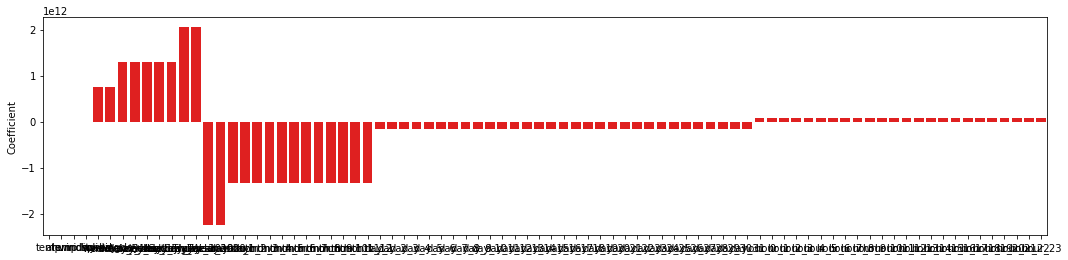

In [613]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics


lr = LinearRegression()
lr.fit(X_train, y_train)


plt.figure(figsize = (18,4))
coeff = pd.DataFrame(lr.coef_, index = X.columns, columns = ['Coefficient'])
sns.barplot(x = coeff.index, y = 'Coefficient', data = coeff, color = 'red')



In [614]:
#Test
y_pred = lr.predict(X_test)
actual_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

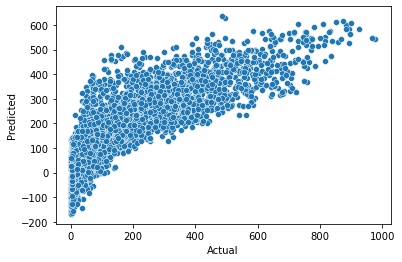

In [615]:
sns.scatterplot(data=actual_predicted, x="Actual", y="Predicted")

In [620]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 9613.62357749784


# Test Ridge Regression

In [627]:
from sklearn.linear_model import Ridge

temp_mse = 9999.9
for i in np.linspace(0, 20, 60):
    rr = Ridge(alpha= i, normalize=True)
    rr.fit(X_train, y_train)
    rr_pred = rr.predict(X_test)

    mse = metrics.mean_squared_error(y_test, rr_pred)
    #print('Mean Squared Error:', mse)
    if(mse < temp_mse):
        temp_mse = mse
print('Mean Squared Error:', temp_mse)

Mean Squared Error: 9613.616622304367


In [629]:
from sklearn.linear_model import Lasso

temp_mse = 9999.9
for i in np.logspace(-10, -1, 60):
    lassor = Ridge(alpha= i, normalize=True, tol = 0.1)
    lassor.fit(X_train, y_train)
    lassor_pred = lassor.predict(X_test)

    mse = metrics.mean_squared_error(y_test, rr_pred)
    #print('Mean Squared Error:', mse)
    if(mse < temp_mse):
        temp_mse = mse
print('Mean Squared Error:', temp_mse)

SyntaxError: invalid syntax (<ipython-input-629-fc3e83cd5638>, line 7)